## I. 들어가며

실험실에서 딥러닝을 의료 영상 분석에 적용할 프로젝트를 고민한 적이 있었고, 그 일환으로 폐(Lung)의 컴퓨터 단층촬영(CT: Computed Tomography) 영상에서 결절 혹은 암 따위의 오브젝트를 판별하기 위한 연구가 계획되었다. 당시 나는 딥러닝 모델에 투입될 데이터를 전처리하는 역할을 맡았는데, 이와 유사한 기존의 연구나 프로젝트들이 상당히 많았기에 진행에 큰 어려움은 없었다. 다만 그 과정들이 단순치 않아 간략히 기록으로 남긴다.

## II. 데이터 세트
LUNA16(LUng Nodule Analysis 2016) 챌린지는 폐 CT 영상 데이터 세트를 내려 받을 수 있는 링크를 제공하며, 이 데이터 세트가 LIDC/IDRI 데이터 세트임을 고지하고 있다. 이 포스트에서 사용할 데이터는 실제 CT 영상을 포함하고 있는 subset\*.zip과 각 영상 내 결절 후보들의 좌표와 클래스 정보를 포함하고 있는 candidates_V2.csv 파일이다. 참고로 subset\*.zip은 개개의 용량이 수 기가바이트를 상회하므로 내려 받는데 상당한 시간이 소요된다.

## III. 파이썬 및 라이브러리
파이썬은 다른 프로그래밍 언어보다 접근성이 좋았고 훌륭한 딥러닝 라이브러리들이 이 언어를 지원하였기에 사용하지 않을 이유가 없었다. 사용된 파이썬 버전은 3.6.5 이고 라이브러리 목록은 아래와 같다.
* NumPy 1.16.0 - 여러 가지 계산 함수 활용
* Pandas 0.23.4 - candidates_V2.csv 파일 처리
* SciPy 1.2.0 - 이미지 인터폴레이션
* SimpleITK 1.2.0 - .mhd 파일 처리
* Matplotlib 3.0.2 - 이미지 플로팅
* tqdm 4.29.1 - 작업 진행률 모니터링(옵션)

개발자는 리눅스 터미널이나 윈도우 명령 프롬프트에서 pip 명령어를 통해 이들을 개별적으로 설치하거나, 아니면 아나콘다를 사용할 수도 있다. 가상 환경(Virtual Environment)이나 미리 세팅된 도커(Docker) 컨테이너도 선택지가 될 수 있으니 자세한 내용은 해당 공식 홈페이지를 참고하는 것이 좋다.

## IV. 전처리
CT 영상 전처리를 처음 접했을 당시, 나는 이 영상이 단순히 이미지들의 묶음 정도로 구성되었을 것이다라고 생각했는데 의외로 더 복잡한 개념을 포함하고 있었다. LUNA16 데이터 전처리가 골치 아팠던 이유는 *.mhd 파일의 Pixel(엄밀히 말하자면 voxel) space와 Physical space 간 상호변환 개념이 매우 생소했다는 점, 그리고 Slicing thickness 를 핸들링하지 못해 특정 축의 이미지가 이상해 보인다는 점이었다. 내려받은 CT 영상이 *.dcm 이 아닌  *.mhd 파일 확장자(Insight Meta-Image)였다는 것도 한 몫 했다. 나는 이것들의 관계나 차이를 아직 명확히 알지 못하기 때문에 세부 내용은 다시 업데이트 할 것이다.

### CT 영상 열어보기

In [1]:
import os
from glob import glob

import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

%matplotlib inline


"""
/notebooks
    │
    ├ /datasets
    │    ├ /luna16
    │    │   ├ candidates_V2.csv
    │    │   └ /subset0
    │    │        ├ 1.3.6.1....1260.mhd
    │    │        ├ 1.3.6.1....1260.raw
    │    │        └ ...
    │    └ ...
    │
    ├ /luna16
    │    └ preprocessing.ipynb
    └ ...
"""
mhd_files = glob(os.path.join('../datasets/luna16/subset0', '*.mhd'))
len(mhd_files)

89

위 코드의 주석문에서 /datasets/luna16 에는 CT 영상 내 결절 후보들의 정보를 담고있는 파일 candidates_V2.csv 와 실제 CT 영상 파일들이 위치한 디렉토리 subset0 가 들어있다. 참고로 코드 테스트 편의를 위해 subset0 만을 사용하였으며, 이 코드가 실행될 주피터 노트북(Jupyter Notebook) 파일은 preprocessing.ipynb 이다. 먼저 디렉토리 subset0 내 .mhd 확장자를 갖는 파일들의 이름을 리스트로 저장한다. Out[1]은 이 파일들의 개수를 나타낸다.

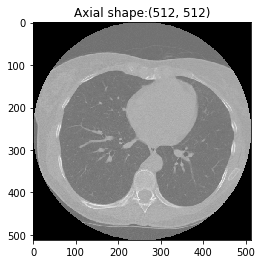

In [2]:
img = sitk.ReadImage(mhd_files[0])
imgarr = sitk.GetArrayFromImage(img)

img_axial = imgarr[len(imgarr)//2] # =imgarr[len(...)//2, :, :]
plt.title("Axial shape:" + str(np.shape(img_axial)))
plt.imshow(img_axial, cmap='gray')

위 코드는 첫 번째 mhd 파일을 불러와 영상을 확인하는 과정이다. 변수 img에 첫 번재 파일의 raw 데이터를 저장한 후 이를 다시 3차원(z, y, x) 리스트로 변환하여 변수 imgarr 에 저장하였다. 라인 4는 리스트의 z축 이미지 중 가운데에 위치한 녀석을 가져와 이미지로 출력한다. 출력 이미지는 양자화된 배열이므로 이 상태 그대로 직렬화하면 될 것 같지만 사실은 그렇지 않다.

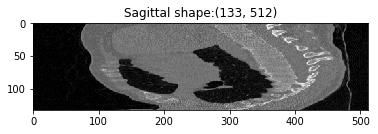

In [3]:
img_sagittal = imgarr[:, :, len(imgarr[0][0])//2]
plt.title("Sagittal shape:" + str(np.shape(img_sagittal)))
plt.imshow(img_sagittal, cmap='gray')

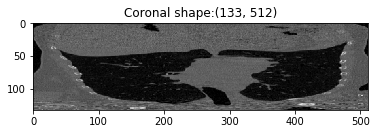

In [4]:
img_coronal = imgarr[:, len(imgarr[0])//2, :]
plt.title("Coronal shape:" + str(np.shape(img_coronal)))
plt.imshow(img_coronal, cmap='gray')

출력 2가 Axial plane 이미지라면 출력 3과 4는 각각 Sagittal, Coronal plane 이미지를 나타내며, 육안으로 두 가지 이상한 점을 관찰할 수 있다. 첫 째, 출력 3과 4의 흉부 길이가 비정상적으로 짧다. 이는 CT 촬영 장비에 설정된 슬라이싱 두께를 고려하지 않고 리스트 imgarr 을 만들었기 때문이다. 둘 째, 가장 어두운 곳과 가장 밝은 곳의 명도 차이가 크다. 이는 픽셀값의 상대적인 차이에 따라 이미지를 표현하는 라이브러리의 특성 때문이다.


결과적으로 슬라이싱 두께를 고려하여 리스트 imgarr 의 각 요소 위치를 다시 계산하여야 하며, 이 과정은 추후 실수 값으로 저장된 결절 후보의 x, y, z 축 좌표를 복셀 좌표로 변환하는 계산에도 정확히 동일하게 적용되어야 한다. 또한 모든 imgarr (89개) 의 픽셀값의 상하한을 통일시키는 과정도 필요하다.

### 리샘플 및 노멀라이즈

앞선 내용에서 리스트 imgarr 의 리샘플링이 왜 필요한지에 대하여 서술하였다. 즉, 결절 후보의 좌표를 통해 해당 영역을 크롭하려면 Physical sapce 를 Voxel space 로 변환하는 처리가 가장 먼저 선행되어야 한다는 것이다. 이 과정은 다소 복잡하기에 별도의 함수를 미리 구현한다. 다음 코드의 리샘플 부분은 Guido Zuidhof [1]의 코드를 참고하였다.

In [5]:
from scipy.ndimage import interpolation


def _real_resize_factor(shape, spacing, adj_spacing=None):
    if adj_spacing is None:
        adj_spacing = list(np.ones_like(shape))
    new_shape = np.round(shape * (spacing / adj_spacing))
    real_resize_factor = new_shape / shape
    return real_resize_factor


def resample(imgarr, spacing):
    real_resize_factor = _real_resize_factor(imgarr.shape, spacing)
    spacing = spacing / real_resize_factor
    imgarr = interpolation.zoom(imgarr, real_resize_factor, mode='nearest')
    return imgarr, spacing


def normalize(imgarr, norm_min, norm_max):
    imgarr = np.where(imgarr < norm_min, norm_min, imgarr)
    imgarr = np.where(imgarr > norm_max, norm_max, imgarr)
    imgarr = (imgarr + abs(norm_min)) / (abs(norm_min) + abs(norm_max))
    return imgarr

함수 \_real_resize_factor() 는 imgarr 의 축(z, y, x)별 리사이징 계수를 반환하고, 함수 resample() 은 이를 이용하여 재계산된(변환된) imgarr 과 spacing 정보를 반환한다. 함수 normalize()는 imgarr 의 픽셀값을 미리 지정된 상하한에 따라 조절하는데, 하운스필드 유닛(HU: Hounsfield Unit) 스케일에 맞게 처리하여야 한다. 리샘플 및 노멀라이즈를 적용하는 코드는 아래와 같다.

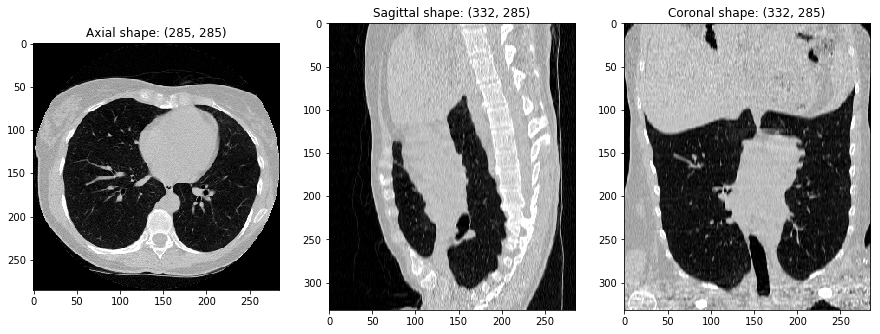

In [6]:
origin = np.array(img.GetOrigin())[::-1]
spacing = np.array(img.GetSpacing())[::-1]

imgarr, spacing = resample(imgarr, spacing)
imgarr = normalize(imgarr, -1000, 400)

img_titles = ['Axial', 'Sagittal', 'Coronal']
img_planes = [
    imgarr[len(imgarr)//2],
    imgarr[:, :, len(imgarr[0][0])//2],
    imgarr[:, len(imgarr[0])//2, :]
]

fig, axes = plt.subplots(1, 3, figsize=(15, 10))
for i in range(len(img_titles)):
    axes[i].set_title(img_titles[i] + ' shape: ' + str(img_planes[i].shape))
    axes[i].imshow(img_planes[i], cmap='gray')
plt.show()

위 코드의 1, 2번 라인은 mhd 파일에 저장된 origin 및 spacing 정보를 가져오는 것이고, 그 다음 라인부터는 리샘플 및 노멀라이즈 후 이미지를 출력하는 과정이다. 출력 1, 2, 그리고 3에 비하여 흉부 길이와 밝기가 정상적으로 표현되는 것을 확인할 수 있다. 지금까지 폐 CT 영상 전처리 중 가장 선행되어야 할 처리에 대하여 서술하였다. 다음 포스트는 리샘플에 적용된 계산을 결절 후보 좌표에도 적용하고, 이를 통해 해당 결절의 영역을 크롭하는 처리를 다룰 것이다.